In [10]:
import os, sys
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 
sys.path.insert(0, parentdir) 
sys.path.insert(0, currentdir + "\Code") 

### Calculates basins of attraction under weight noise

In [11]:
import math
import pickle
import numpy as np
from scipy.optimize import curve_fit
import sklearn.decomposition
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib import rc
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
import scipy
from scipy.integrate import odeint, DOP853, solve_ivp
from scipy.stats import special_ortho_group
from itertools import chain, combinations, permutations
import seaborn as sns

from ring_functions_noorman import *

"""cmap = 'gray'
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)"""

"cmap = 'gray'\nrc('font', **{'family': 'serif', 'serif': ['Computer Modern']})\nrc('text', usetex=True)"

In [141]:
# symmetric cosine weight matrix W sym jk = JI + JE cos(theta_j - theta_K)
# where JE and JI respectively control the strength of the tuned and untuned components of recurrent connectivity between neurons with preferred headings theta_j and theta_k.

# For a network of size N , there are N 3 such “optimal” values of local excitation J*E

# The parameters (JI, JE) can be set such that this system will generate a population profile that qualitatively looks like a discretely sampled “bump” of activity.
# (JI, JE) are within the subset  \Omega = \OmegaJI\times\OmegaJE \subset (−1, 1) \times (2,1)

def get_corners(N, m):
    #works for even N
    corners = []
    corner_0 = np.array([m]*N)
    corner_0[int(N/2):] *= -1
    corner_0[int(N/2)-int(N/4):int(N/2)] = 0
    corner_0[N-int(N/4):] = 0
    for support_j in range(N):
        corners.append(np.roll(corner_0, support_j))
    corners = np.array(corners)
    return corners

def get_bumps_along_oneside_ring(N, m, corners, step_size=0.1):
    x = np.arange(0, m+step_size, step_size)
    n_xs = x.shape[0]
    bumps = np.zeros((N, n_xs))
    for i, x_i in enumerate(x):
        for j in range(N):
            bumps[j,i] = np.interp(x_i, [0,m], [corners[0][j],corners[1][j]])
    return bumps

def get_all_bumps(N, bumps):
    all_bumps = []
    for support_j in range(N):
        for bump_i in range(bumps.shape[1]):
            all_bumps.append(np.roll(bumps[:,bump_i], support_j))
    all_bumps = np.array(all_bumps)
    return all_bumps

def get_all_bumps_2darray(N, bumps):
    all_bumps = np.zeros((N,bumps.shape[1],N))
    for support_j in range(N):
        for bump_i in range(bumps.shape[1]):
            all_bumps[support_j,bump_i] = np.roll(bumps[:,bump_i], support_j)
    return all_bumps

def get_noorman_symmetric_weights(N, J_I = 1, J_E = 1):
    # W sym jk = JI + JE cos(theta_j - theta_K)
    x = np.arange(0,N,1)
    row = J_I + J_E*np.cos(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W


# W asym jk =sin(theta_j - theta_k)
def get_noorman_asymmetric_weights(N):
    # W asym jk =sin(theta_j - theta_k)
    x = np.arange(0,N,1)
    row = np.sin(2*np.pi*x/N)
    W = scipy.linalg.circulant(row)
    return W

def noorman_ode(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N):
    """Differential equation of head direction network in Noorman et al., 2022. 
    tau: integration constant
    transfer_function: each neuron transforms its inputs via a nonlinear transfer function
    W_sym, W_asym: symmetric and asymmetric weight matrices
    v_in: input
    c_ff: a constant feedforward input to all neurons in the network
    N: number of neurons in the network
    """

    return (-x + np.dot(W_sym+v_in(t)*W_asym, transfer_function(x))/N + c_ff)/tau

def noorman_ode_with_noise(t,x,tau,transfer_function,W_sym,W_asym,c_ff,N,noises):
    """Differential equation of head direction network in Noorman et al., 2022. 
    tau: integration constant
    transfer_function: each neuron transforms its inputs via a nonlinear transfer function
    W_sym, W_asym: symmetric and asymmetric weight matrices
    v_in: input
    c_ff: a constant feedforward input to all neurons in the network
    N: number of neurons in the network
    """
    if noises is not None:
        return (-x + np.dot(W_sym+v_in(t)*W_asym, transfer_function(x))/N + c_ff + noises[round(t)])/tau
    else:
        return (-x + np.dot(W_sym+v_in(t)*W_asym, transfer_function(x))/N + c_ff)/tau

# Fixed points and their stabilities
def noorman_jacobian(x, W_sym):
    N = W_sym.shape[0]
    
    r = np.where(x>0)
    W_sub = np.zeros((N,N))
    W_sub[:,r] = W_sym[:,r]
    J = -np.eye(N)
    J += W_sub/N
    return J

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def noorman_fixed_points(W_sym, c_ff):
    """
    Takes as argument all the parameters of the recurrent part of the model (W_sym, c_ff)
    \dot x = -x + 1/N W_sym ReLU(x) + c_ff = 0
    """
    fixed_point_list = []

    N = W_sym.shape[0]
    subsets = powerset(range(N))
    for support in subsets:
        if support == ():
            continue
        r = np.array(support)
        
        W_sub = np.zeros((N,N))
        W_sub[:,r] = W_sym[:,r]
        A = W_sub/N - np.eye(N)
        fixed_point = -np.dot(np.linalg.inv(A), np.ones(N)*c_ff)
        
        #check true fixed point
        negativity_condition = True
        # print(r, [item for item in range(N) if item not in r])
        for i in r:
            if fixed_point[i] <= 0:
                negativity_condition = False
        for i in [item for item in range(N) if item not in r]:
            if fixed_point[i] >= 0:
                negativity_condition = False
        
        if negativity_condition:
            fixed_point_list.append(fixed_point)
        
    fixed_point_array = np.array(fixed_point_list)
    return fixed_point_array

def v_in(t):
    return 0

def ReLU(x):
    return np.where(x<0,0,x)



In [142]:
def get_network(N,J_E,J_I):
    W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
    W_asym = get_noorman_asymmetric_weights(N)
    c_ff = 1.

    maxT = 100
    n_timesteps = 100
    t = np.linspace(0, maxT, n_timesteps)

    y0 = np.random.uniform(0,1,N)

    sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,maxT], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)

    m = np.max(sol.sol(t)) # m #round? what should the maximum be according to the paper?
    corners = get_corners(N, m)
    bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=0.05)
    step_size = .1
    x = np.arange(0, m+step_size, step_size)
    all_bumps = get_all_bumps(N, bumps)
    return corners, all_bumps, W_sym, W_asym, t

def get_network_with_automatic_corners(N,J_E,J_I,t):
    W_sym = get_noorman_symmetric_weights(N, J_I, J_E)
    W_asym = get_noorman_asymmetric_weights(N)
    c_ff = 1.

    y0 = np.random.uniform(0,1,N)

    sol = solve_ivp(noorman_ode, y0=y0,  t_span=[0,t[-1]], t_eval=t, args=tuple([tau, transfer_function, W_sym, W_asym, c_ff, N]),dense_output=True)

    corners=[]
    for support_j in range(N):
        corners.append(np.roll(sol.sol(t)[:,-1], support_j))
    corners = np.array(corners)

    m = np.max(sol.sol(t)) # m #round? what should the maximum be according to the paper?
    bumps = get_bumps_along_oneside_ring(N, m, corners, step_size=m/5)
    all_bumps = get_all_bumps(N, bumps)

    return corners, all_bumps, W_sym, W_asym

def get_perturbation(seed,norm,W_sym_max,N):
    np.random.seed(seed)
    eps = np.random.uniform(-1,1,(N,N))
    eps /= np.linalg.norm(eps)
    eps *= norm * W_sym_max / 100 # perturbation norm as percentage of maximum neural activity
    return eps

def get_trajectories(eps,all_bumps,W_sym, W_asym, t, N):

    trajectories = np.zeros((all_bumps.shape[0], len(t), N))
    noises=None
    for i in range(all_bumps.shape[0]):
        sol = solve_ivp(noorman_ode_with_noise, y0=all_bumps[i,:],  t_span=[0,t[-1]], t_eval=t, args=tuple([tau, transfer_function, W_sym+eps, W_asym, c_ff, N, noises]),dense_output=True)
        trajectories[i] = sol.sol(t).T
    return trajectories

In [143]:
def von_mises(x, A, kappa, mu, C):
    """Von Mises function (circular Gaussian-like)"""
    return A * np.exp(kappa * (np.cos(x - mu) - 1)) + C

import numpy as np

def get_angle_from_bump(activity, sigma_smooth=3):
    """
    Compute the center of mass (CoM) and smooth peak location for a bump in a ring attractor.

    Parameters:
        activity (1D numpy array): Activity values along the ring.
        sigma_smooth (float): Smoothing width for peak estimation (default: 3).

    Returns:
        com_angle (float): Center of mass in radians.
        peak_smooth (float): Smoothed peak location in radians.
    """
    N = len(activity)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)  # Circular angles

    # Compute circular center of mass (CoM)
    x_com = np.sum(np.cos(angles) * activity)
    y_com = np.sum(np.sin(angles) * activity)
    com_angle = np.arctan2(y_com, x_com)

    # Find initial peak location
    peak_idx = np.argmax(activity)
    
    # Define Gaussian weights centered on peak
    idxs = np.arange(N)
    distances = np.minimum(np.abs(idxs - peak_idx), N - np.abs(idxs - peak_idx))  # Circular distance
    weights = np.exp(-0.5 * (distances / sigma_smooth) ** 2)  # Gaussian weights
    
    # Compute weighted average of angles
    peak_smooth = np.arctan2(
        np.sum(weights * np.sin(angles) * activity),
        np.sum(weights * np.cos(angles) * activity)
    )

    return com_angle, peak_smooth

def get_angle_diffs(trajectories):
    centre_of_mass_diffs, peak_location_diffs = [], []
    for trajectory in trajectories:
        initial_state = trajectory[0]
        final_state = trajectory[-1]
        centre_of_mass_initial, peak_location_initial = get_angle_from_bump(initial_state)
        centre_of_mass_final, peak_location_final = get_angle_from_bump(final_state)

        centre_of_mass_diff = np.abs(centre_of_mass_final-centre_of_mass_initial)
        centre_of_mass_diff = np.min([centre_of_mass_diff, 2*np.pi-centre_of_mass_diff])
        centre_of_mass_diffs.append(np.degrees(centre_of_mass_diff))

        peak_location_diff = np.abs(peak_location_final-peak_location_initial)
        peak_location_diff = np.min([peak_location_diff, 2*np.pi-peak_location_diff])
        peak_location_diffs.append(np.degrees(peak_location_diff))

    return centre_of_mass_diffs, peak_location_diffs

In [144]:
def plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N,eps):

    pca = sklearn.decomposition.PCA(n_components=2)

    corners_proj = pca.fit_transform(corners)

    if fixed_points is not None:
        fixed_points_proj = pca.transform(fixed_points.reshape(-1,N))

    points_on_manifold_proj = pca.transform(inv_man)

    trajectory_states_proj = pca.transform(trajectories[trajectory_index])
    final_trajectory_state_proj = pca.transform(trajectories[trajectory_index,-1].reshape(-1,N))
    initial_trajectory_state_proj = pca.transform(trajectories[trajectory_index,0].reshape(-1,N))
    intermediate_timestep = 1
    intermediate_trajectory_state_proj = pca.transform(trajectories[trajectory_index,intermediate_timestep].reshape(-1,N))

    for i in range(points_on_manifold_proj.shape[0]):
        plt.plot(points_on_manifold_proj[i,0], points_on_manifold_proj[i,1], '.', color='m', label="Analytical", zorder=99, alpha=0.1, markersize= 5)

    for i in range(N):
        plt.plot([corners_proj[i-1,0], corners_proj[i,0]],
                [corners_proj[i-1,1], corners_proj[i,1]],
                'k', label="Original attractor", zorder=0, alpha=0.1, linewidth=10, 
                solid_capstyle='round')

    if fixed_points is not None:
        for i in range(fixed_points.shape[0]):
            eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_points[i], W_sym+eps))
            if np.all(np.real(eigenvalues)<0):
                plt.plot(fixed_points_proj[i,0], fixed_points_proj[i,1], '*', color="darkblue", label="Stable", zorder=10, alpha=1., markersize=15) # final states of the trajectories 
            else:
                plt.plot(fixed_points_proj[i,0], fixed_points_proj[i,1], '*', color="darkorange", label="Stable", zorder=10, alpha=1., markersize=15) # final states of the trajectories 
            
    #plt.plot(fixed_point_proj[:,0], fixed_point_proj[:,1], '^b', label="Stable", zorder=10, alpha=1., markersize=20) # final states of the trajectories 
    
    plt.plot(trajectory_states_proj[:,0], trajectory_states_proj[:,1], '.k', label="Stable", zorder=10, alpha=1., markersize=10) # final states of the trajectories 
    plt.plot(initial_trajectory_state_proj[:,0], initial_trajectory_state_proj[:,1], '.g', label="Stable", zorder=10, alpha=1., markersize=20) # final states of the trajectories 
    #plt.plot(intermediate_trajectory_state_proj[:,0], intermediate_trajectory_state_proj[:,1], '.m', label="Stable", zorder=10, alpha=1., markersize=20) # final states of the trajectories 
    plt.plot(final_trajectory_state_proj[:,0], final_trajectory_state_proj[:,1], '.r', label="Stable", zorder=10, alpha=1., markersize=20) # final states of the trajectories 


In [145]:
def get_speed_and_acceleration(trajectory):
    speeds = []
    accelerations = []
    for t in range(trajectory.shape[0]-1):
        speed = np.linalg.norm(trajectory[t+1, :]-trajectory[t, :])
        speeds.append(speed)
    for t in range(trajectory.shape[0]-2):
        acceleration = np.abs(speeds[t+1]-speeds[t])
        accelerations.append(acceleration)
    speeds = np.array(speeds)
    accelerations = np.array(accelerations)
    return speeds, accelerations

def get_speed_and_acceleration_batch(trajectories):
    all_speeds = []
    all_accs = []
    for trajectory in trajectories:
        speeds, accelerations = get_speed_and_acceleration(trajectory)
        all_speeds.append(speeds)
        all_accs.append(accelerations)
    return np.array(all_speeds), np.array(all_accs)

def detect_slow_manifold(trajectories, subsample=10, tol=0):
    # for each trajectory, gets the index at which the speed starts to be low enough & 
    # from those points extract all onwards timesteps, with steps of 10 timesteps 
    all_speeds, all_accs = get_speed_and_acceleration_batch(trajectories)
    idx = np.argmax(all_speeds - all_speeds[:,-1][:,np.newaxis] < tol,axis=1)
    inv_man = np.empty((0,trajectories.shape[-1]))
    for i,index in enumerate(idx):
        inv_man = np.vstack([inv_man, trajectories[i,index::subsample,:]])
    return inv_man

def detect_slow_manifold_keep_time(trajectories, tol=0):
    all_speeds, all_accs = get_speed_and_acceleration_batch(trajectories)
    idx = np.argmax(all_speeds - all_speeds[:,-1][:,np.newaxis] < tol,axis=1)
    s = all_speeds - all_speeds[:,-1][:,np.newaxis]
    inv_man = []#np.empty((0,trajectories.shape[-1]))
    for i,index in enumerate(idx):
        inv_man.append(trajectories[i,index:index+2,:])
    return np.array(inv_man)

# Get results for one (seed,norm) combination

16


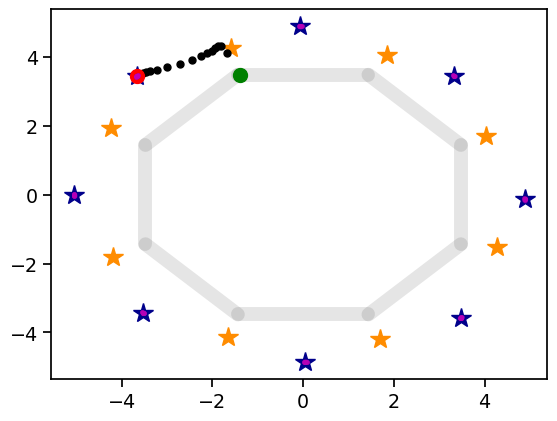

In [16]:
N, J_E, J_I = 8, 5, -3
seeds = [27, 0, 3, 13, 418, 1550] #33->0
norms =  [1e-10, 1e-5, 1e-1, .5, 1, 1.1, 1.5]
seed=seeds[0]
norm=norms[3]

np.random.seed(seed)
eps = np.random.uniform(-1,1,(N,N))
eps /= np.linalg.norm(eps)
eps *= norm

corners, all_bumps, W_sym, W_asym, t = get_network(N,J_E,J_I)
trajectories = get_trajectories(eps,all_bumps,W_sym, W_asym, t, N)
fixed_points = noorman_fixed_points(W_sym+eps, c_ff)[:-1]
print(len(fixed_points))

inv_man = detect_slow_manifold(trajectories,tol=1e-2)
trajectory_index=166
plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N,eps)

angle_diffs, peak_location_diffs = np.array(get_angle_diffs(trajectories))

### Find range of good (J_E, J_I) combinations. Possible limits: 
######    * 1e-2 < neural activity < 1e2
######    * number of fixed points = 0
######    * points on invariant manifold have time constant score < threshold

###### Only use 1e-2 < neural activity < 1e2 limit. For this purpose, N does not make much of a difference, since the max & min neural activities are given by J_E & J_I in the weights rather than by N. The valid combinations are therefore only calculated for N=6 (although larger Ns could lead to slightly more valid combinations).


In [ ]:
N=6 # only run for N=6 because for this task N doesn't make a difference, the weights only depend on J_E and J_I
activity_limits_exceeded = []
zero_fixed_points = []
large_time_constant_score = []
symmetric_matrix = []
valid_JE_JI_combinations_N6 = []


tau, c_ff = 1, 1
transfer_function = ReLU
maxT  = 100
num_seeds = 10
np.random.seed(0)
seeds = np.random.randint(0, 2**15, size=num_seeds)
norms =  [1e-5, 1e-2, 1e-1, 0.5, 1, 2, 2.5, 3]
N_range = np.concatenate((np.arange(6,20,2), np.arange(20,84,4)))

for J_E in np.arange(1,15,1)[:]:
    for J_I in np.arange(-1,-15,-1)[:]:
        corners, all_bumps, W_sym, W_asym, t = get_network_with_automatic_corners(N,J_E,J_I)
        if (corners.max() > 100) or (corners.min() < -100):
            activity_limits_exceeded.append((J_E,J_I))
        else:
            try:
                fixed_points = noorman_fixed_points(W_sym, c_ff)[:-1]
                n_fixed_points = len(fixed_points)
            except: # attractor is continuous
                symmetric_matrix.append((J_E,J_I))
                n_fixed_points = 0
            if n_fixed_points == 0:
                zero_fixed_points.append((J_E,J_I))
            else: # check rate of speed parallel / speed normal to manifold is small
                for fixed_point in fixed_points:
                    eigenvalues, _ = scipy.linalg.eig(noorman_jacobian(fixed_point, W_sym))
                    if np.all(np.real(eigenvalues)<0): # check whether stable point
                        sorted_eigenvalues = np.sort(np.abs(eigenvalues))
                        time_constant_score = sorted_eigenvalues[0] / sorted_eigenvalues[1]
                        if time_constant_score > 0.5:
                            large_time_constant_score.append((J_E,J_I))
                            break
        if ((J_E,J_I) not in activity_limits_exceeded) :
            valid_JE_JI_combinations_N6.append((J_E,J_I))

In [10]:
len(valid_JE_JI_combinations_N6), valid_JE_JI_combinations_N6

(157,
 [(1, -1),
  (1, -2),
  (1, -3),
  (1, -4),
  (1, -5),
  (1, -6),
  (1, -7),
  (1, -8),
  (1, -9),
  (1, -10),
  (1, -11),
  (1, -12),
  (1, -13),
  (1, -14),
  (2, -1),
  (2, -2),
  (2, -3),
  (2, -4),
  (2, -5),
  (2, -6),
  (2, -7),
  (2, -8),
  (2, -9),
  (2, -10),
  (2, -11),
  (2, -12),
  (2, -13),
  (2, -14),
  (3, -1),
  (3, -2),
  (3, -3),
  (3, -4),
  (3, -5),
  (3, -6),
  (3, -7),
  (3, -8),
  (3, -9),
  (3, -10),
  (3, -11),
  (3, -12),
  (3, -13),
  (3, -14),
  (4, -1),
  (4, -2),
  (4, -3),
  (4, -4),
  (4, -5),
  (4, -6),
  (4, -7),
  (4, -8),
  (4, -9),
  (4, -10),
  (4, -11),
  (4, -12),
  (4, -13),
  (4, -14),
  (5, -1),
  (5, -2),
  (5, -3),
  (5, -4),
  (5, -5),
  (5, -6),
  (5, -7),
  (5, -8),
  (5, -9),
  (5, -10),
  (5, -11),
  (5, -12),
  (5, -13),
  (5, -14),
  (6, -2),
  (6, -3),
  (6, -4),
  (6, -5),
  (6, -6),
  (6, -7),
  (6, -8),
  (6, -9),
  (6, -10),
  (6, -11),
  (6, -12),
  (6, -13),
  (6, -14),
  (7, -3),
  (7, -4),
  (7, -5),
  (7, -6),
  (7, -

# Get results for several combinations

##### Define parameters

In [97]:
valid_JE_JI = [(10,-6),(10,-7),(10,-8),(10,-9),(10,-10),(10,-11),(10,-12),(10,-13),(10,-14),
               (9,-5),(9,-6),(9,-7),(9,-8),(9,-9),(9,-10),(9,-11),(9,-12),(9,-13),(9,-14),
               (8,-5),(8,-6),(8,-7),(8,-8),(8,-9),(8,-10),(8,-11),(8,-12),(8,-13),(8,-14),
               (7,-4),(7,-5),(7,-6),(7,-7),(7,-8),(7,-9),(7,-10),(7,-11),(7,-12),(7,-13),(7,-14),
               (6,-3),(6,-4),(6,-5),(6,-6),(6,-7),(6,-8),(6,-9),(6,-10),(6,-11),(6,-12),(6,-13),(6,-14),
                (5,-2),(5,-3),(5,-4),(5,-5),(5,-6),(5,-7),(5,-8),(5,-9),(5,-10),(5,-11),(5,-12),(5,-13),(5,-14),
                (4,-1),(4,-2),(4,-3),(4,-4),(4,-5),(4,-6),(4,-7),(4,-8),(4,-9),(4,-10),(4,-11),(4,-12),(4,-13),(4,-14),
                (3,-1),(3,-2),(3,-3),(3,-4),(3,-5),(3,-6),(3,-7),(3,-8),(3,-9),(3,-10),(3,-11),(3,-12),(3,-13),(3,-14),
               ]

In [147]:
tau, c_ff = 1, 1
transfer_function = ReLU

maxT = 20
n_timesteps = maxT
t = np.linspace(0,maxT,n_timesteps)

num_seeds = 10
np.random.seed(0)
seeds = np.random.randint(0, 2**15, size=num_seeds)
norms =  [0.01, 0.1, 0.5, 1, 3, 5, 10] #old norms=[1e-5,1e-2,0.1,0.5,1,2,2.5,3] 

#N_range = np.concatenate((np.arange(6,20,2), np.arange(20,84,4))) # include first few Ns which have fixed point calculations and Ns from 20 onwards which don't
N_range = np.arange(6,20,2)

##### Run simulations over all parameter combinations

In [ ]:
def get_results(t,N,J_E,J_I,seed,norm):

    corners, all_bumps, W_sym, W_asym = get_network_with_automatic_corners(N,J_E,J_I,t)
    W_sym_max = np.abs(W_sym).max()

    pert = get_perturbation(seed,norm,W_sym_max,N)

    trajectories = get_trajectories(pert,all_bumps,W_sym, W_asym, t, N)

    # Check presence of fixed points or invariant manifold
    if N<20:
        try:
            fixed_points = noorman_fixed_points(W_sym+pert, c_ff)[:-1]
            n_fixed_points = len(fixed_points)
        except:
            n_fixed_points = 0
    else:
        n_fixed_points = 0

    # inv_man = detect_slow_manifold(trajectories,tol=1e-2)
    # trajectory_index=1
    # plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N,pert)

    angle_diffs, peak_location_diffs = np.array(get_angle_diffs(trajectories))
    return angle_diffs, n_fixed_points

for N in N_range:
    for combination in valid_JE_JI: # here valid_JE_JI_combinations is calculated with N=6 and only combinations in activity_limits_exceeded are excluded; symmetric matrix & zero fixed points combinations are kept
        J_E, J_I = combination[0], combination[1]
        results = {}
        for seed in seeds:
            for norm in norms:
                print(N,J_E,J_I,seed,norm)
                results[(N,J_E,J_I,seed,norm)] = get_results(t,N,J_E,J_I,seed,norm)
        with open("results//all_JE_JI//weight_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "wb") as f:
            pickle.dump(results, f)
        del results

6 10 -6 2732 0.01
6 10 -6 2732 0.1
6 10 -6 2732 0.5
6 10 -6 2732 1
6 10 -6 2732 3
6 10 -6 2732 5
6 10 -6 2732 10
6 10 -6 10799 0.01
6 10 -6 10799 0.1
6 10 -6 10799 0.5
6 10 -6 10799 1
6 10 -6 10799 3
6 10 -6 10799 5
6 10 -6 10799 10
6 10 -6 9845 0.01
6 10 -6 9845 0.1
6 10 -6 9845 0.5
6 10 -6 9845 1
6 10 -6 9845 3
6 10 -6 9845 5
6 10 -6 9845 10
6 10 -6 19648 0.01
6 10 -6 19648 0.1
6 10 -6 19648 0.5
6 10 -6 19648 1
6 10 -6 19648 3
6 10 -6 19648 5
6 10 -6 19648 10
6 10 -6 13123 0.01
6 10 -6 13123 0.1
6 10 -6 13123 0.5
6 10 -6 13123 1
6 10 -6 13123 3
6 10 -6 13123 5
6 10 -6 13123 10
6 10 -6 21243 0.01
6 10 -6 21243 0.1
6 10 -6 21243 0.5
6 10 -6 21243 1
6 10 -6 21243 3
6 10 -6 21243 5
6 10 -6 21243 10
6 10 -6 30403 0.01
6 10 -6 30403 0.1
6 10 -6 30403 0.5
6 10 -6 30403 1
6 10 -6 30403 3
6 10 -6 30403 5
6 10 -6 30403 10
6 10 -6 32103 0.01
6 10 -6 32103 0.1
6 10 -6 32103 0.5
6 10 -6 32103 1
6 10 -6 32103 3
6 10 -6 32103 5
6 10 -6 32103 10
6 10 -6 9225 0.01
6 10 -6 9225 0.1
6 10 -6 9225 0.5
6 

# Analyze results

### Number of fixed points

dict_keys([(10, 14, -9, 2732, 1e-05), (10, 14, -9, 2732, 0.01), (10, 14, -9, 2732, 0.1), (10, 14, -9, 2732, 0.5), (10, 14, -9, 2732, 1), (10, 14, -9, 2732, 2), (10, 14, -9, 2732, 2.5), (10, 14, -9, 2732, 3), (10, 14, -9, 10799, 1e-05), (10, 14, -9, 10799, 0.01), (10, 14, -9, 10799, 0.1), (10, 14, -9, 10799, 0.5), (10, 14, -9, 10799, 1), (10, 14, -9, 10799, 2), (10, 14, -9, 10799, 2.5), (10, 14, -9, 10799, 3), (10, 14, -9, 9845, 1e-05), (10, 14, -9, 9845, 0.01), (10, 14, -9, 9845, 0.1), (10, 14, -9, 9845, 0.5), (10, 14, -9, 9845, 1), (10, 14, -9, 9845, 2), (10, 14, -9, 9845, 2.5), (10, 14, -9, 9845, 3), (10, 14, -9, 19648, 1e-05), (10, 14, -9, 19648, 0.01), (10, 14, -9, 19648, 0.1), (10, 14, -9, 19648, 0.5), (10, 14, -9, 19648, 1), (10, 14, -9, 19648, 2), (10, 14, -9, 19648, 2.5), (10, 14, -9, 19648, 3), (10, 14, -9, 13123, 1e-05), (10, 14, -9, 13123, 0.01), (10, 14, -9, 13123, 0.1), (10, 14, -9, 13123, 0.5), (10, 14, -9, 13123, 1), (10, 14, -9, 13123, 2), (10, 14, -9, 13123, 2.5), (10,

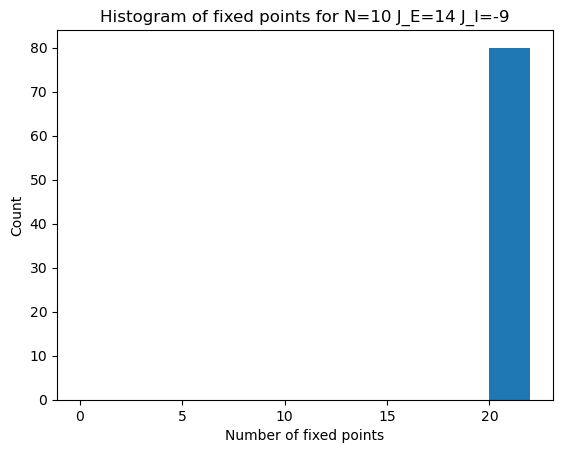

In [105]:
def get_n_fixed_points(N,J_E,J_I):
    with open("results//all_JE_JI//weight_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
        results = pickle.load(f)
    print(results.keys())
    n_fixed_points = []
    for seed in seeds:
        for norm in norms:
            n_fixed_points.append(results[(N,J_E,J_I,seed,norm)][1])
    n_fixed_points = np.array(n_fixed_points)
    #n_fixed_points = n_fixed_points.reshape(len(np.arange(2,6,0.1)),len(seeds),len(norms))
    return n_fixed_points

def get_hist_n_fixed_points_N_JE_JI(n_fixed_points,N,J_E,J_I):
    plt.hist(n_fixed_points,bins=range(0,2*N+4,2))
    plt.title('Histogram of fixed points for N={} J_E={} J_I={}'.format(N,J_E,J_I))
    plt.xlabel('Number of fixed points')
    plt.ylabel('Count')

def get_hist_n_fixed_points(n_fixed_points,N):
    plt.hist(n_fixed_points,bins=range(0,2*N+4,2))
    plt.title('Histogram of fixed points for N={}'.format(N))
    plt.xlabel('Number of fixed points')
    plt.ylabel('Count')

N=10
J_E=14
J_I=-9
n_fixed_points = get_n_fixed_points(N,J_E,J_I)
get_hist_n_fixed_points_N_JE_JI(n_fixed_points,N,J_E,J_I)

###### Use the valid combinations obtained with N=6, some of which lead to symmetric matrices or to 0 fixed points (even under weight perturbations). The combinations that lead to symmetric matrices or zero fixed points are generally the same for different N. Use these combinations, but exclude them from the plot below.

#### Number of fixed points for all (N,J_E,J_I,seed,norm) combinations

(array([ 5.71428571,  2.85714286,  5.71428571,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 85.71428571]),
 array([0.125 , 0.3125, 0.5   , 0.6875, 0.875 , 1.0625, 1.25  , 1.4375,
        1.625 , 1.8125, 2.    ]),
 <BarContainer object of 10 artists>)

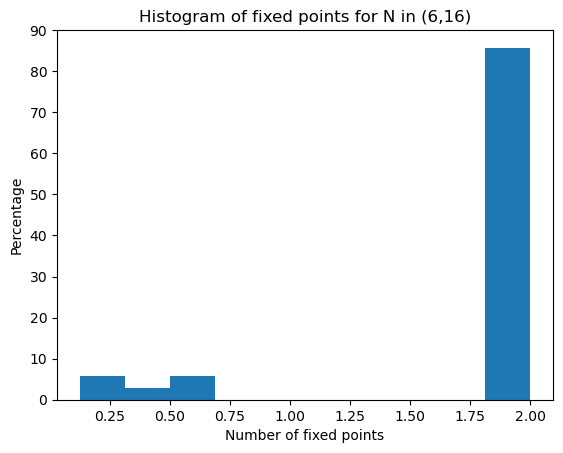

In [107]:
tau, c_ff = 1, 1
transfer_function = ReLU
maxT  = 100
n_fixed_points_all = []
N_range = np.arange(6,18,2)
valid_JE_JI_combinations, valid_combinations = [], []

# Extract valid combinations from all Ns, i.e. combinations that lead to non-zero fixed points (zero fixed points could happen either because the weight matrix is symmetric, or because there is just an invariant manifold with no fixed points)
for N in N_range:
    n_fixed_points = []
    for combination in valid_JE_JI:
        J_E, J_I = combination[0], combination[1]
        with open("results//all_JE_JI//weight_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
            results = pickle.load(f)
        for seed in seeds:
            for norm in norms:
                if results[(N,J_E,J_I,seed,norm)][1] != 0:
                    n_fixed_points.append(results[(N,J_E,J_I,seed,norm)][1]/N)

weights = 100*np.ones_like(n_fixed_points) / len(n_fixed_points)
plt.title('Histogram of fixed points for N in ({},{})'.format(N_range[0],N_range[-1]))
plt.xlabel('Number of fixed points')
plt.ylabel('Percentage')
plt.hist(n_fixed_points, weights=weights)

In [108]:
len(valid_JE_JI), len(valid_combinations), len(n_fixed_points) # 95-108 JE 8; JE 11; JE 6

(93, 0, 7280)

#### Number of fixed points for a subset of (N,J_E,seed,norm) combinations

##### Different seeds

(array([ 0.94015549,  2.08596999,  2.55152775,  1.6452721 ,  4.9787561 ,
        2.71876695,  1.457693  ,  0.66895679,  0.        ,  2.79560658,
        0.        ,  0.18305912,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 77.50180799]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]), <BarContainer object of 19 artists>)
(array([ 0.95746105,  2.08900594,  2.54876579,  1.6247824 ,  4.97478016,
        2.73847253,  1.48863991,  0.66062581,  0.        ,  2.76079097,
        0.        ,  0.18077936,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 77.50301299]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]), <BarContainer object of 19 artists>)
(array([ 0.9456838 ,  2.06331011,  2.60338594,  1.63345384,  4.98633277,
        2.70478794,  1.4703289 ,  0.65249978,  0.        ,  2.784

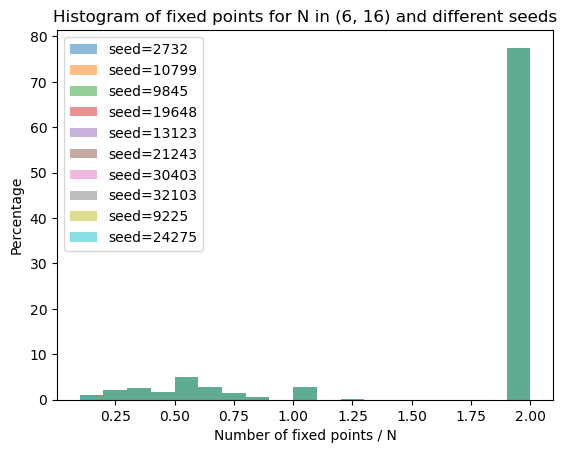

In [308]:
def get_hist_specific_combinations(N_range,valid_JE_JI,plot_seed,norms,alpha):

    for N in N_range:
        for combination in valid_JE_JI: # Exclude J_E = 2 because it sometimes generates 0 fixed points, so it might not be a valid attractor; for them, check presence of limit cycles
            J_E,J_I = combination[0], combination[1]
            with open("results//all_JE_JI//weight_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
                results = pickle.load(f)
            for norm in norms:
                n_fixed_points.append(results[(N,J_E,J_I,plot_seed,norm)][1] / N) # Divide the number of fixed points by their respective N

    weights = 100*np.ones_like(n_fixed_points) / len(n_fixed_points)
    plt.title(f'Histogram of fixed points for N in {N_range[0],N_range[-1]} and different seeds')
    plt.xlabel('Number of fixed points / N')
    plt.ylabel('Percentage')
    #plt.hist(n_fixed_points, weights=weights, bins=np.arange(0.1,2.1,0.1), alpha=alpha, label=f"norm={norm}")
    print(plt.hist(n_fixed_points, weights=weights, bins=np.arange(0.1,2.1,0.1), alpha=alpha, label=f"seed={plot_seed}"))
    plt.legend()
    
N_range = np.arange(6,18,2)

for seed in seeds:
    get_hist_specific_combinations(N_range,valid_JE_JI,seed,norms,alpha=0.5)

#### Different norms

(array([ 0.92249442,  2.05360949,  2.5538477 ,  1.66570547,  4.98733733,
        2.75294   ,  1.446052  ,  0.67726486,  0.        ,  2.80058173,
        0.        ,  0.1647401 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 77.49805672]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]), <BarContainer object of 19 artists>)
(array([ 0.92152878,  2.04927378,  2.55291727,  1.66906261,  4.98934219,
        2.75566351,  1.44896644,  0.67862985,  0.        ,  2.80622614,
        0.        ,  0.16507213,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 77.48475685]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]), <BarContainer object of 19 artists>)
(array([ 0.92058514,  2.04503688,  2.55200804,  1.67234324,  4.99130136,
        2.75832496,  1.45181446,  0.67996374,  0.        ,  2.811

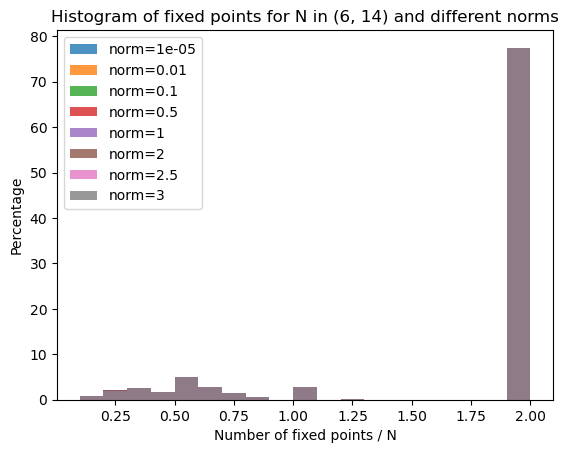

In [309]:
def get_hist_specific_combinations(N_range,valid_JE_JI,seeds,plot_norm,alpha):

    for N in N_range:
        for combination in valid_JE_JI: # Exclude J_E = 2 because it sometimes generates 0 fixed points, so it might not be a valid attractor; for them, check presence of limit cycles
            J_E,J_I = combination[0], combination[1]
            with open("results//all_JE_JI//weight_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
                results = pickle.load(f)
            for seed in seeds:
                n_fixed_points.append(results[(N,J_E,J_I,seed,plot_norm)][1] / N) # Divide the number of fixed points by their respective N

    weights = 100*np.ones_like(n_fixed_points) / len(n_fixed_points)
    plt.title(f'Histogram of fixed points for N in {N_range[0],N_range[-1]} and different norms')
    plt.xlabel('Number of fixed points / N')
    plt.ylabel('Percentage')
    #plt.hist(n_fixed_points, weights=weights, bins=np.arange(0.1,2.1,0.1), alpha=alpha, label=f"norm={norm}")
    print(plt.hist(n_fixed_points, weights=weights, bins=np.arange(0.1,2.1,0.1), alpha=alpha, label=f"norm={plot_norm}"))
    plt.legend()
    
N_range = np.arange(6,16,2)
np.random.seed(0)
seeds = np.random.randint(0, 2**15, size=num_seeds)
norms =  [1e-5, 1e-2, 1e-1, 0.5, 1, 2, 2.5, 3]
for norm in norms:
    get_hist_specific_combinations(N_range,valid_JE_JI,seeds,norm,alpha=0.8)

## Angle errros

### Single combination: maximum angular error

Text(0, 0.5, 'Angular error (degrees)')

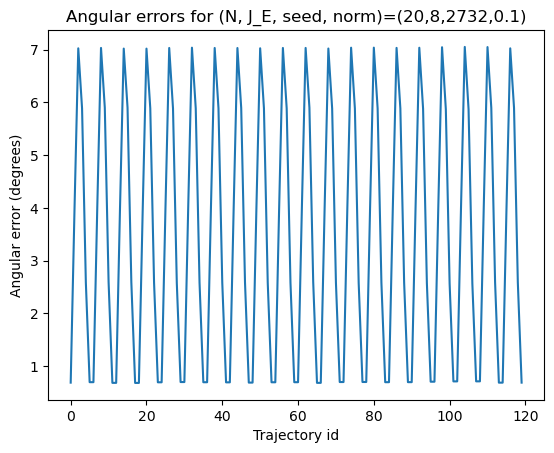

In [114]:
N, J_E, J_I, seed, norm = 20, 8, -5, seeds[0], norms[2]
with open("results//all_JE_JI//weight_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
        results = pickle.load(f)
angle_errors = results[(N,J_E,J_I,seed,norm)][0]

plt.plot(angle_errors)
plt.title('Angular errors for (N, J_E, seed, norm)=({},{},{},{})'.format(N,J_E,seed,norm))
plt.xlabel('Trajectory id')
plt.ylabel('Angular error (degrees)')

### Multiple (N,J_E,J_I,seed,norm) combinations: maximum angular error

In [137]:
def extract_angle_errors(N_range,valid_JE_JI,filter_bool,filter_idx,filter_value):
    all_angle_errors = {}
    counts = {}
    for N_idx, N in enumerate(N_range):
        for combination in valid_JE_JI:
            J_E, J_I = combination[0], combination[1]

            with open("results//all_JE_JI//weight_noise//angle_errors_{}_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
                    results = pickle.load(f)
            for seed in seeds:
                for norm in norms:

                    # replace one of the parameters with the one from the fn arguments
                    param_comb = [N,J_E,J_I,seed,norm]
                    if filter_bool:
                        param_comb[filter_idx] = filter_value
                    angle_errors = results[tuple(param_comb)][0]
                    
                    if N in list(all_angle_errors.keys()):
                        all_angle_errors[N] = np.max((all_angle_errors[N], np.max(angle_errors)))
                    else:
                        all_angle_errors[N] = np.max(angle_errors)
                        
                    if N in list(counts.keys()):
                        counts[N] += 1
                    else:
                        counts[N] = 1
    return list(all_angle_errors.values()), list(counts.values())

##### Variation across norms

Text(0, 0.5, 'Angular error')

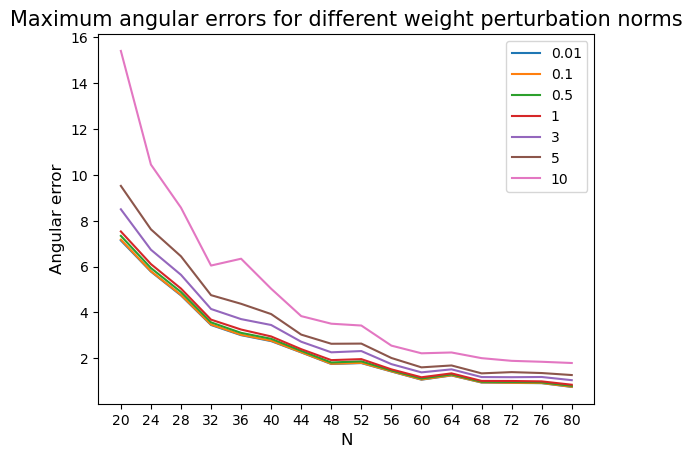

In [133]:
filter_bool=True
filter_idx=-1
for norm in norms:
    angle_errors, counts = extract_angle_errors(N_range,valid_JE_JI,filter_bool,filter_idx,norm)
    plt.plot(angle_errors, label=f'{norm}')
plt.legend()
plt.xticks(np.arange(len(angle_errors)),N_range)
plt.title('Maximum angular errors for different weight perturbation norms',fontsize=15)
plt.xlabel('N',fontsize=12)
plt.ylabel('Angular error',fontsize=12)

#### Variation across seeds

Text(0, 0.5, 'Angular error')

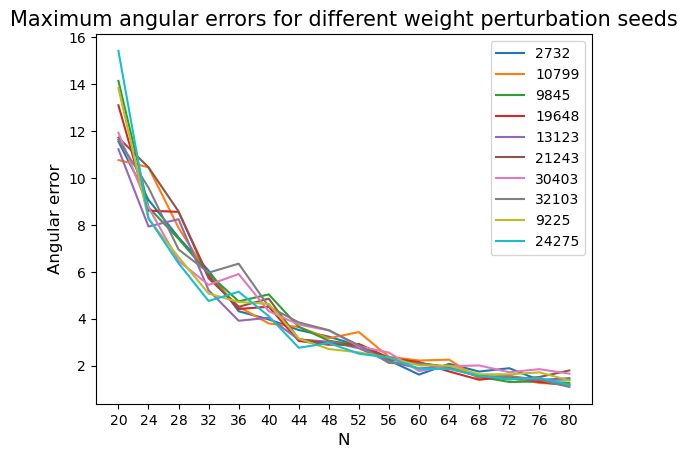

In [135]:
filter_bool=True
filter_idx=-2
for seed in seeds:
    angle_errors, counts = extract_angle_errors(N_range,valid_JE_JI,filter_bool,filter_idx,seed)
    plt.plot(angle_errors, label=f'{seed}')
plt.legend()
plt.xticks(np.arange(len(angle_errors)),N_range)
plt.title('Maximum angular errors for different weight perturbation seeds',fontsize=15)
plt.xlabel('N',fontsize=12)
plt.ylabel('Angular error',fontsize=12)

##### Maximum angular errors per N

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Angular error')

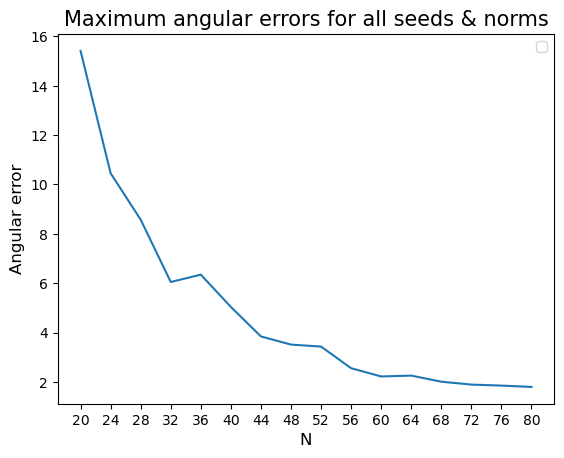

In [139]:
filter_bool=False
filter_idx=-2
seed=seeds[0]

angle_errors, counts = extract_angle_errors(N_range,valid_JE_JI,filter_bool,filter_idx,seed)
plt.plot(angle_errors)
plt.legend()
plt.xticks(np.arange(len(angle_errors)),N_range)
plt.title('Maximum angular errors for all seeds & norms',fontsize=15)
plt.xlabel('N',fontsize=12)
plt.ylabel('Angular error',fontsize=12)

### Trajectory visualization

[ 0.          1.05263158  2.10526316  3.15789474  4.21052632  5.26315789
  6.31578947  7.36842105  8.42105263  9.47368421 10.52631579 11.57894737
 12.63157895 13.68421053 14.73684211 15.78947368 16.84210526 17.89473684
 18.94736842 20.        ]


26.428531013198693

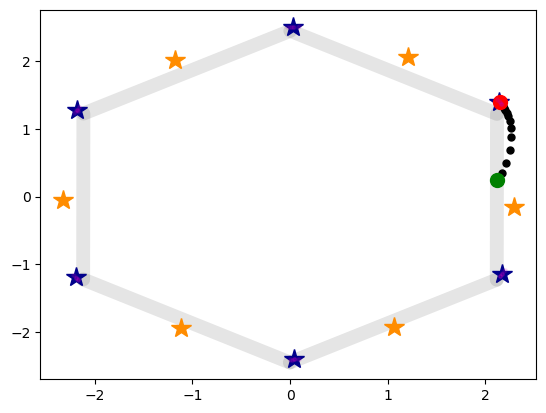

In [96]:
seed, norm = seeds[3], norms[-1]
N=6
J_E, J_I = 3, -1

corners, all_bumps, W_sym, W_asym = get_network_with_automatic_corners(N,J_E,J_I,t)
W_sym_max = np.abs(W_sym).max()

np.random.seed(seed)
eps = np.random.uniform(-1,1,(N,N))
eps /= np.linalg.norm(eps)
eps *= norm * W_sym_max / 100 # perturbation norm as percentage of maximum neural activity

trajectories = get_trajectories(eps,all_bumps,W_sym, W_asym, t, N)
fixed_points = noorman_fixed_points(W_sym+eps, c_ff)[:-1]
#print(len(fixed_points))

inv_man = detect_slow_manifold(trajectories,tol=1e-2)
trajectory_index=3

plot_trajectory_and_invariant_manifold(corners,inv_man,fixed_points,trajectories,trajectory_index,N,eps)
with open("results//all_JE_JI//weight_noise//angle_errors_{}_{}.pkl".format(N,J_E,J_I), "rb") as f:
        results = pickle.load(f)
angle_error = results[N,J_E,J_I,seed,norm]
plt.title('Angular error: {} degrees'.format(round(angle_error)))